In [2]:
import os
import re
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
import squidpy as sq
import anndata as ad
import seaborn as sns
from matplotlib.pyplot import rc_context
from kneed import KneeLocator
from matplotlib.ticker import MaxNLocator
from sklearn.cluster import MiniBatchKMeans

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [4]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


In [5]:
donor = f"combined_04_27"

all_donor = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
    "SP Donor A"
]


# Import data

In [6]:
def get_masks_cp(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split("_")[2].split("Donor")[0]
                masks[condition] = img[:1000, :1000]
            else:
                continue
    return masks

In [7]:
adata_path = data_dir / "metadata" / f"{donor}.h5ad"

In [8]:
adata = sc.read_h5ad(adata_path)

In [9]:
if "combined" in donor:
    masks = {}
    for d in all_donor:
        masks[d] = get_masks_cp(data_dir / "masks_cp" / d)
else:
    masks = get_masks_cp(data_dir / "masks_cp" / donor)

In [10]:
adata = adata[adata.obs['Dataset'].isin(all_donor)]

In [11]:
df_cluster = sc.get.obs_df(adata, keys=['Dataset', 'clusters'])
df_cluster_count = df_cluster.value_counts().to_frame('counts').reset_index()
df_cluster_count['Density'] = df_cluster_count.groupby('Dataset')["counts"].apply(lambda x: x / x.sum())
df_cluster_count['Dataset'] = pd.Categorical(df_cluster_count['Dataset'])

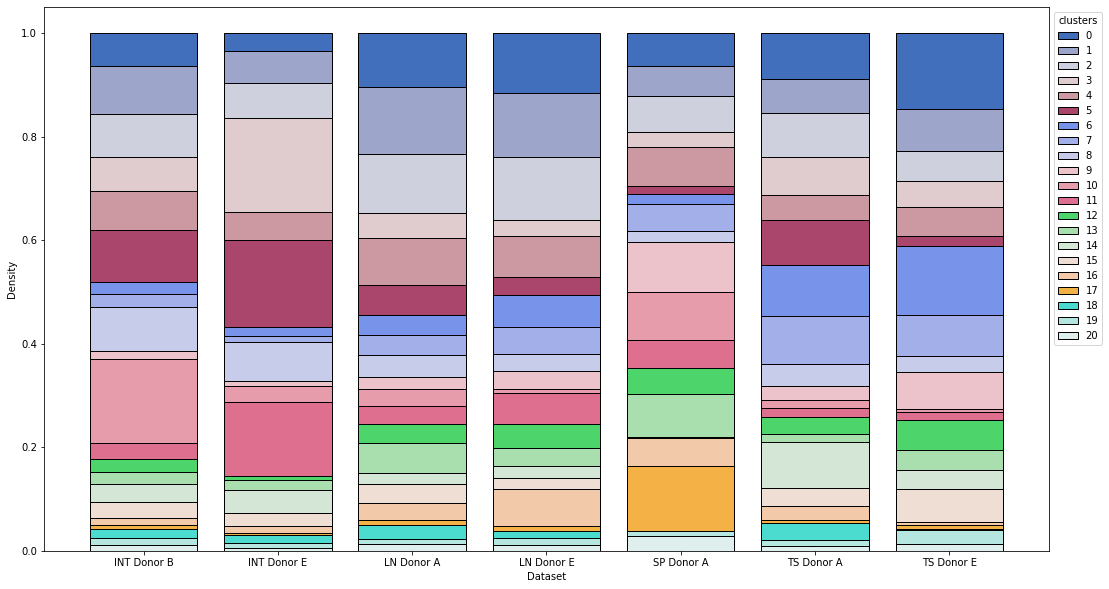

In [12]:
fig, ax = plt.subplots(figsize=(18, 10))
ax = sns.histplot(data=df_cluster_count, x='Dataset' , hue='clusters', weights='Density',
             multiple='stack', shrink=0.8, palette=adata.uns['clusters_colors'].tolist())
ax.set_ylabel('Density')
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
ax.grid(False)

In [13]:
df_count = pd.pivot_table(df_cluster_count, values='Density', index='Dataset', columns='clusters')

adata_count = ad.AnnData(df_count.values)
adata_count.var_names = df_count.columns.tolist()
adata_count.obs['Dataset'] = df_count.index.tolist()
adata_count.obs['Dataset'] = adata_count.obs['Dataset'].astype('category')

C:\Users\thu71\AppData\Local\Temp/ipykernel_156132/30411856.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_count = ad.AnnData(df_count.values)


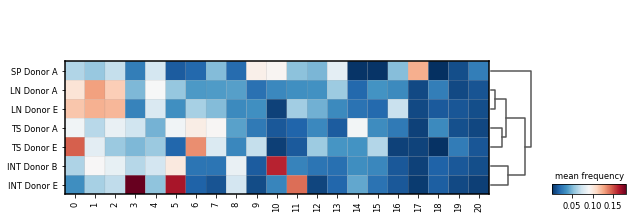

In [14]:
sc.pl.matrixplot(
    adata_count,
    adata_count.var_names.tolist(),
    "Dataset",
    dendrogram=True,
    colorbar_title="mean frequency",
    cmap="RdBu_r",

)